In [1]:
import pandas as pd

DATA_PATH = "../data/raw/yellow_tripdata_2015-01.parquet"

df = pd.read_parquet(DATA_PATH)

df.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [2]:
print("Shape:", df.shape)
df.info()

Shape: (12748986, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12748986 entries, 0 to 12748985
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   RateCodeID             int64  
 8   store_and_fwd_flag     object 
 9   dropoff_longitude      float64
 10  dropoff_latitude       float64
 11  payment_type           int64  
 12  fare_amount            float64
 13  extra                  float64
 14  mta_tax                float64
 15  tip_amount             float64
 16  tolls_amount           float64
 17  improvement_surcharge  float64
 18  total_amount           float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.8+ GB


In [3]:
# transform the columns type in datetime
df["pickup_datetime"] = pd.to_datetime(
    df["tpep_pickup_datetime"], errors="coerce"
)
df["dropoff_datetime"] = pd.to_datetime(
    df["tpep_dropoff_datetime"], errors="coerce"
)
# Uso errors="coerce" perché così, invece di bloccarsi, pandas sostituisce quel valore problematico con NaT (Not a Time),
# che è il valore nullo standard per le date in Python (simile al NaN per i numeri)
df[["pickup_datetime", "dropoff_datetime"]].isnull().sum()



pickup_datetime     0
dropoff_datetime    0
dtype: int64

In [5]:
# creation of the target variable
df["trip_duration_seconds"] = (
    df["dropoff_datetime"] - df["pickup_datetime"]
).dt.total_seconds()

df["trip_duration_seconds"].describe()


count    1.274899e+07
mean     8.507402e+02
std      3.895807e+04
min     -7.266100e+04
25%      3.660000e+02
50%      5.970000e+02
75%      9.470000e+02
max      3.291334e+07
Name: trip_duration_seconds, dtype: float64

In [6]:
# search how many weird values are there
df[df["trip_duration_seconds"] <= 0].shape
df[df["trip_duration_seconds"] > 3 * 60 * 60].shape

(10430, 22)

In [7]:
# create a mask that will be the filter fot the rows to be removed
invalid_duration_mask = (
    (df["trip_duration_seconds"] <= 0) |
    (df["trip_duration_seconds"] > 3 * 60 * 60)
)

# analysis of the impact on the df
invalid_count = invalid_duration_mask.sum()
total_count = len(df)

print(f"{invalid_count} rows will be removed with this mask"
      f"({invalid_count / total_count:.4%} of total)")


25543 rows will be removed with this mask(0.2004% of total)


In [8]:
# remove the rows with the filter
df = df[~invalid_duration_mask]

df["trip_duration_seconds"].describe()

count    1.272344e+07
mean     7.373502e+02
std      5.531148e+02
min      1.000000e+00
25%      3.660000e+02
50%      5.970000e+02
75%      9.470000e+02
max      1.079800e+04
Name: trip_duration_seconds, dtype: float64

let's modify other columns considered as important features

In [9]:
df["trip_distance"].describe()

count    1.272344e+07
mean     1.348229e+01
std      9.853971e+03
min      0.000000e+00
25%      1.000000e+00
50%      1.680000e+00
75%      3.000000e+00
max      1.542000e+07
Name: trip_distance, dtype: float64

In [10]:
df[df["trip_distance"] <= 0].shape

(64936, 22)

In [11]:
df["fare_amount"].describe()



count    1.272344e+07
mean     1.189882e+01
std      1.018977e+01
min     -4.500000e+02
25%      6.500000e+00
50%      9.000000e+00
75%      1.350000e+01
max      4.008000e+03
Name: fare_amount, dtype: float64

In [12]:
df[df["fare_amount"] <= 0].shape

(7191, 22)

In [13]:
df = df[
    (df["trip_distance"] > 0) &
    (df["fare_amount"] > 0)
]
df["fare_amount"].describe()

count    1.265349e+07
mean     1.186604e+01
std      9.852318e+00
min      1.000000e-02
25%      6.500000e+00
50%      9.000000e+00
75%      1.350000e+01
max      4.008000e+03
Name: fare_amount, dtype: float64

In [15]:
# spatial coordinates control (the data should come from New York)
df[[
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude"
]].describe()


,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,1.265349e+07,1.265349e+07,1.265349e+07,1.265349e+07
mean,4.002026e+01,-7.264797e+01,4.008746e+01,-7.276853e+01
std,5.409419e+00,9.817745e+00,5.163464e+00,9.377712e+00
min,0.000000e+00,-1.193147e+02,-9.029157e+00,-7.401667e+02
25%,4.073571e+01,-7.399170e+01,4.073455e+01,-7.399121e+01
50%,4.075322e+01,-7.398164e+01,4.075373e+01,-7.397983e+01
75%,4.076762e+01,-7.396677e+01,4.076888e+01,-7.396270e+01
max,4.047000e+02,7.866265e+01,4.595333e+02,8.527402e+01


In [ ]:
# verifico che le coordinate siano all'interno del territorio di New York
df = df[
    df["pickup_latitude"].between(40.5, 41.0) &
    df["pickup_longitude"].between(-74.5, -73.5) &
    df["dropoff_latitude"].between(40.5, 41.0) &
    df["dropoff_longitude"].between(-74.5, -73.5)
]
# Il metodo .between() di pandas è una funzione booleana che serve a filtrare i dati all'interno di un intervallo specifico 
# (estremi inclusi, di default).

In [17]:
df["hour"] = df["pickup_datetime"].dt.hour
df["day_of_week"] = df["pickup_datetime"].dt.weekday
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)


Da escludere perché non rilevanti nella predizione
| Colonna              | Perché                          |
| -------------------- | ------------------------------- |
| `VendorID`           | categorical, basso segnale      |
| `store_and_fwd_flag` | rumore                          |
| `RateCodeID`         | info tariffaria non stabile     |
| `payment_type`       | rischio leakage                 |
| `total_amount`       | **leakage** (dipende dal tempo) |
| `tip_amount`         | post-hoc                        |


In [18]:
# creation of the df that will be used

features = [
    "trip_distance",
    "fare_amount",
    "passenger_count",
    "hour",
    "day_of_week",
    "is_weekend",
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude"
]

target = "trip_duration_seconds"

df_ml = df[features + [target]]


In [ ]:
# verifico di non avere null values
df_ml.isnull().sum()


trip_distance            0
fare_amount              0
passenger_count          0
hour                     0
day_of_week              0
is_weekend               0
pickup_latitude          0
pickup_longitude         0
dropoff_latitude         0
dropoff_longitude        0
trip_duration_seconds    0
dtype: int64

In [20]:
df_ml.head()

,trip_distance,fare_amount,passenger_count,hour,day_of_week,is_weekend,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_duration_seconds
0,1.59,12.0,1,19,3,0,40.750111,-73.993896,40.750618,-73.974785,1083.0
1,3.30,14.5,1,20,5,1,40.724243,-74.001648,40.759109,-73.994415,1190.0
2,1.80,9.5,1,20,5,1,40.802788,-73.963341,40.824413,-73.951820,603.0
3,0.50,3.5,1,20,5,1,40.713818,-74.009087,40.719986,-74.004326,112.0
4,3.00,15.0,1,20,5,1,40.762428,-73.971176,40.742653,-74.004181,1159.0


In [21]:
df_ml.to_parquet(
    "../data/processed/taxi_ml_2015_01.parquet",
    engine="pyarrow",
    index=False
)


# Advanced EDA – NYC Yellow Taxi Trip Data (Jan 2015)

## Obiettivo del notebook
Questo notebook ha tre obiettivi chiave:
1. **Data Quality & Sanity Checks** – capire cosa stiamo modellando davvero
2. **Insight-driven Feature Engineering** – guidare le scelte per il modello
3. **Readiness MLOps** – produrre output riproducibili e utilizzabili in ETL / Feature Store

Il focus non è solo esplorativo, ma **decisionale**.

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

In [4]:
DATA_PATH = "../data/processed/taxi_ml_2015_01.parquet"
df = pd.read_parquet(DATA_PATH)
print(df.shape)
df.head()

(12384390, 13)


,trip_distance,fare_amount,passenger_count,hour,day_of_week,is_weekend,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_duration_seconds,pickup_datetime,trip_id
0,1.59,12.0,1,19,3,0,40.750111,-73.993896,40.750618,-73.974785,1083.0,2015-01-15 19:05:39,0
1,3.30,14.5,1,20,5,1,40.724243,-74.001648,40.759109,-73.994415,1190.0,2015-01-10 20:33:38,1
2,1.80,9.5,1,20,5,1,40.802788,-73.963341,40.824413,-73.951820,603.0,2015-01-10 20:33:38,2
3,0.50,3.5,1,20,5,1,40.713818,-74.009087,40.719986,-74.004326,112.0,2015-01-10 20:33:39,3
4,3.00,15.0,1,20,5,1,40.762428,-73.971176,40.742653,-74.004181,1159.0,2015-01-10 20:33:39,4


## 1. Data Quality Report

### 1.1 Schema & Missing Values

In [5]:
def data_quality_report(df):
    report = pd.DataFrame({
        "dtype": df.dtypes,
        "n_missing": df.isna().sum(),
        "pct_missing": df.isna().mean() * 100,
        "n_unique": df.nunique()
    })
    return report.sort_values("pct_missing", ascending=False)

quality_report = data_quality_report(df)
quality_report

,dtype,n_missing,pct_missing,n_unique
trip_distance,float64,0,0.0,3936
fare_amount,float64,0,0.0,943
passenger_count,int64,0,0.0,10
hour,int32,0,0.0,24
day_of_week,int32,0,0.0,7
is_weekend,int64,0,0.0,2
pickup_latitude,float64,0,0.0,60470
pickup_longitude,float64,0,0.0,32150
dropoff_latitude,float64,0,0.0,85217
dropoff_longitude,float64,0,0.0,50440


**Decisioni:**
- Missing < 1% → drop
- Missing strutturali → imputazione o feature flag

## 2. Target Analysis – Trip Duration

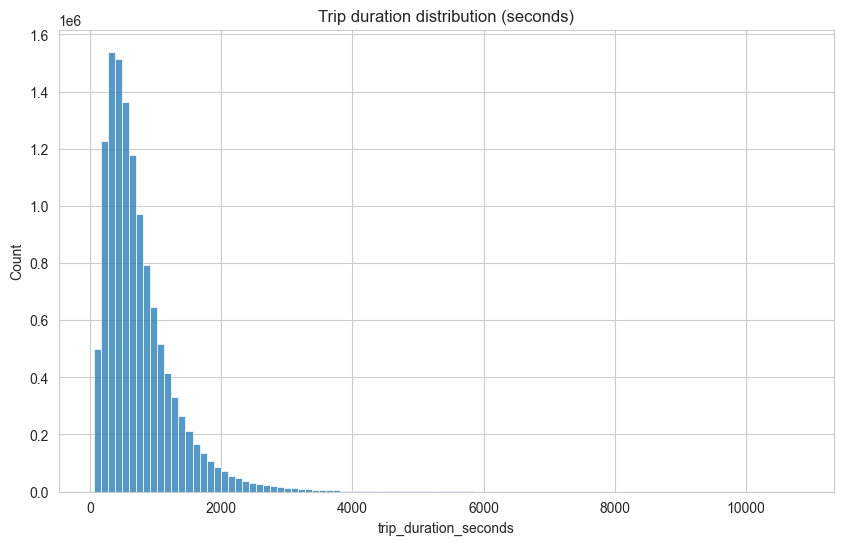

In [6]:
sns.histplot(df["trip_duration_seconds"], bins=100)
plt.title("Trip duration distribution (seconds)")
plt.show()

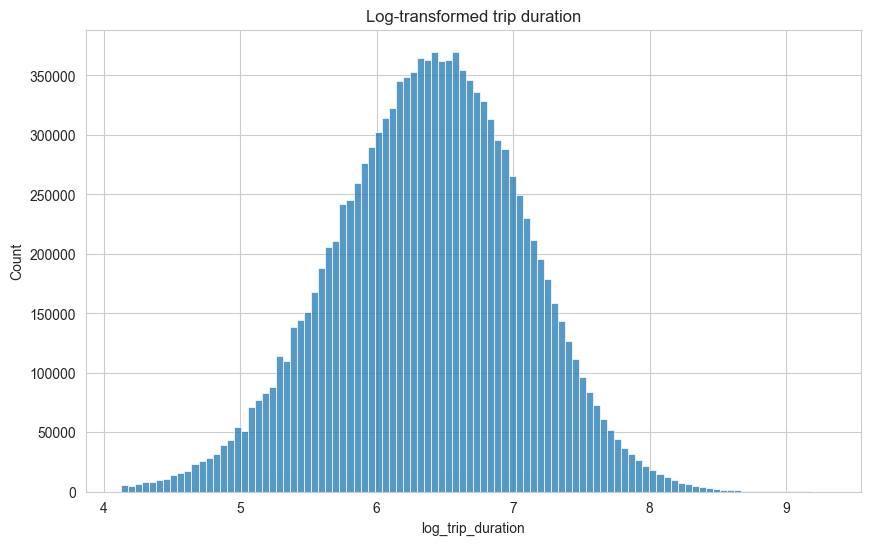

In [7]:
df["log_trip_duration"] = np.log1p(df["trip_duration_seconds"])
sns.histplot(df["log_trip_duration"], bins=100)
plt.title("Log-transformed trip duration")
plt.show()

**Decisione:**
- valutare training su target log-trasformato

## 3. Temporal Analysis

In [8]:
df["hour"] = df["pickup_datetime"].dt.hour
df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

### 3.1 Heatmap Hour × Day of Week

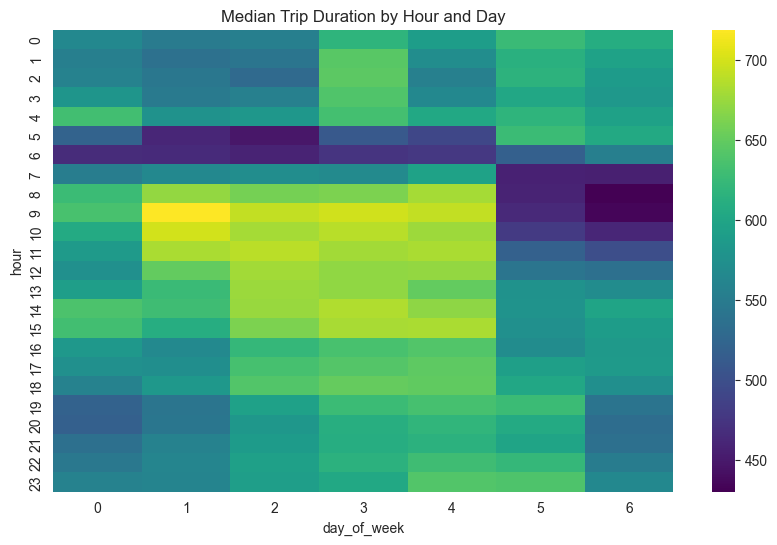

In [9]:
pivot = df.pivot_table(
    index="hour",
    columns="day_of_week",
    values="trip_duration_seconds",
    aggfunc="median"
)

sns.heatmap(pivot, cmap="viridis")
plt.title("Median Trip Duration by Hour and Day")
plt.show()

**Insight:**
- Rush hours e weekend mostrano pattern chiaramente distinti

## 4. Spatial Analysis

### 4.1 Haversine Distance

In [10]:
def haversine(lon1, lat1, lon2, lat2):
    R = 6371000
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))


df["haversine_m"] = haversine(
    df.pickup_longitude,
    df.pickup_latitude,
    df.dropoff_longitude,
    df.dropoff_latitude,
)

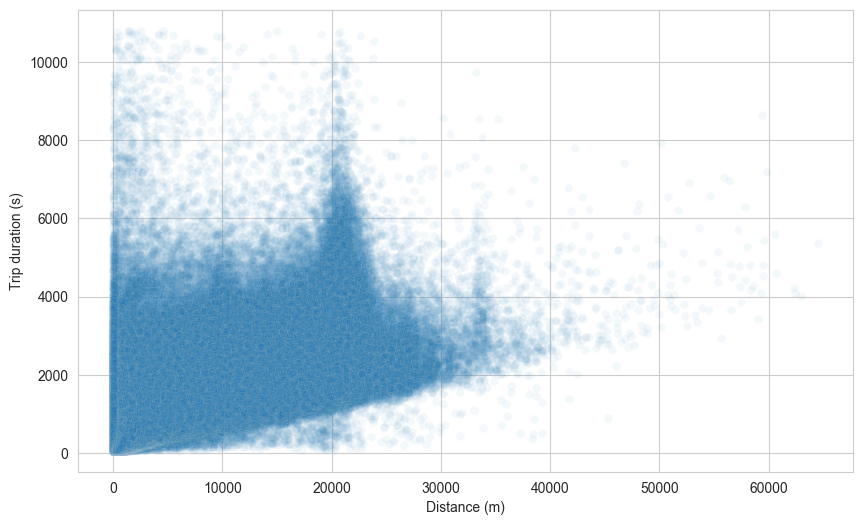

In [11]:
sns.scatterplot(x=df["haversine_m"], y=df["trip_duration_seconds"], alpha=0.05)
plt.xlabel("Distance (m)")
plt.ylabel("Trip duration (s)")
plt.show()

**Insight:**
- Relazione quasi lineare ma con forte rumore → feature fondamentale

## 5. Speed & Fare Consistency

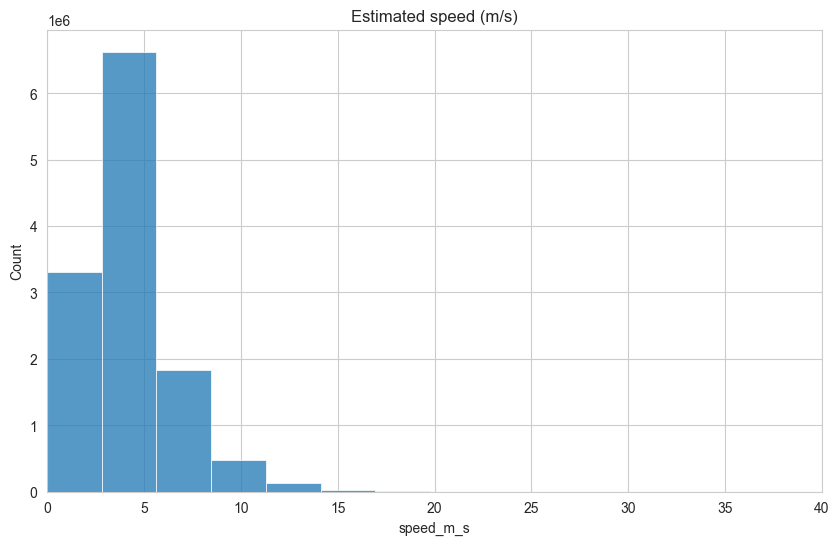

In [12]:
df["speed_m_s"] = df["haversine_m"] / df["trip_duration_seconds"]

sns.histplot(df["speed_m_s"], bins=100)
plt.xlim(0, 40)
plt.title("Estimated speed (m/s)")
plt.show()

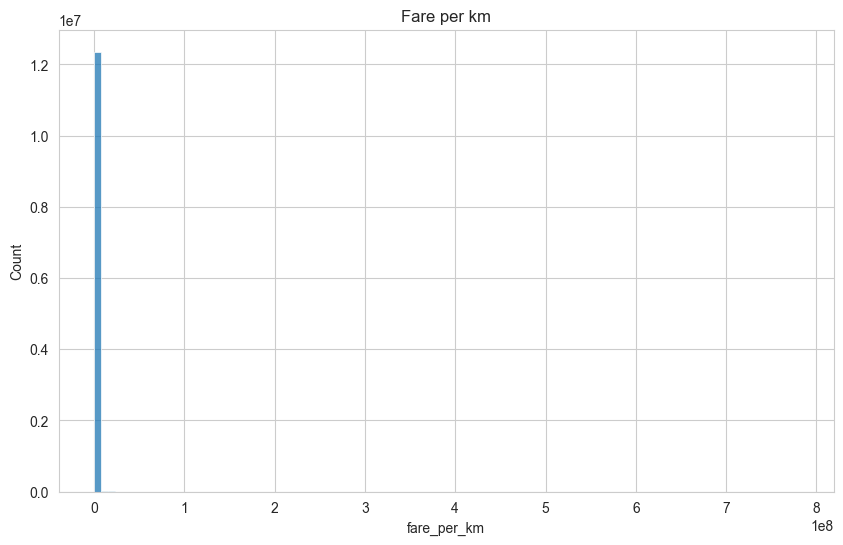

In [ ]:
df["fare_per_km"] = df["fare_amount"] / (df["haversine_m"] / 1000 + 1e-6)
sns.histplot(df["fare_per_km"], bins=100)
plt.title("Fare per km")
plt.show()
#! mi sembra strano il grafico !!!!!

**Decisioni:**
- Speed > 40 m/s → outlier
- Fare/km utile come segnale di anomalie o traffico

## 6. Outlier Detection (Isolation Forest)

In [14]:
from sklearn.ensemble import IsolationForest

features_outlier = df[["trip_duration_seconds", "haversine_m", "fare_amount"]]
iso = IsolationForest(contamination=0.005, random_state=42)

df["is_anomaly"] = iso.fit_predict(features_outlier)

In [15]:
df["is_anomaly"].value_counts(normalize=True)

is_anomaly
 1    0.995011
-1    0.004989
Name: proportion, dtype: float64

**Decisione:**
- Non eliminare ora
- Flag utile per analisi errori modello

## 7. Correlation Analysis

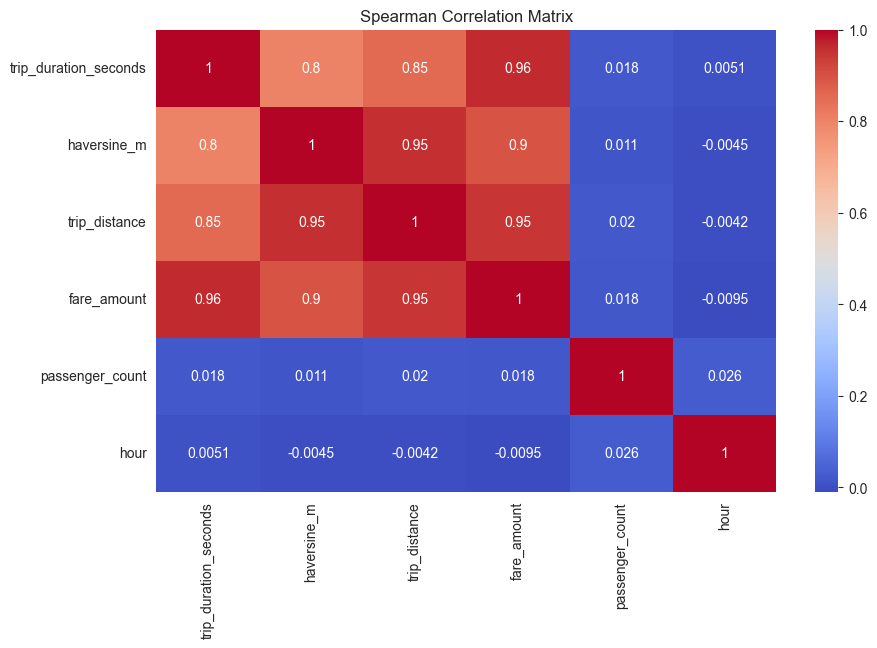

In [16]:
corr_features = [
    "trip_duration_seconds",
    "haversine_m",
    "trip_distance",
    "fare_amount",
    "passenger_count",
    "hour",
]

corr = df[corr_features].corr(method="spearman")
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Spearman Correlation Matrix")
plt.show()

---

## 8. Feature Readiness Summary

### Feature selezionate per il modello:
- haversine_m
- trip_distance
- fare_amount
- passenger_count
- hour
- day_of_week
- is_weekend
- pickup / dropoff coordinates

### Feature escluse (leakage / post-event):
- total_amount
- tip_amount
- dropoff_datetime

## 9. Output per ETL / Feature Store

In [ ]:
OUTPUT_PATH = "../data/processed/training_features.parquet"

features_for_training = [
    "trip_duration_seconds",
    "haversine_m",
    "trip_distance",
    "fare_amount",
    "passenger_count",
    "hour",
    "day_of_week",
    "is_weekend",
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude",
]

df[features_for_training].to_parquet(OUTPUT_PATH, index=False)

## 10. Conclusioni

- Dataset di alta qualità ma rumoroso
- Forte componente spaziale e temporale
- Feature engineering guidata dall’EDA migliora sensibilmente il modello
- Output pronto per pipeline MLOps (Feast + MLflow)

---

📌 **Questo notebook è pensato per essere mostrato in un contesto professionale (MLOps / Data Scientist).**